<a src="https://github.com/nwanne56/cmsc320-finalproj"><h1>The Perfect Summer Anthem</h1></a>
<h3>An analysis of Billboard Hot 100 data by Aman Sheth and David Oguh</h3>
If I asked you to think of a "summer anthem", could you? Most Americans have some concept of the "perfect summer jam", a song perfectly made to be listened to in large group settings, outside, while having a good time. Now if I asked you to describe the specfics of this song (the lyrics involved, the bpm, the general mood), could you? Interestingly, we feel like most people have an idea of what makes a good summer song, but struggle to put this idea into specific numbers and words. In this tutorial, we will examine the most popular summer songs of the past 2 decades, and will try to determine the imperical link between the number of lyrics, the beats per minute, and the mood of the song, and it's general popularity during the summer.  

Let's make our hypothesis clear. It is reasonable, from prior knowledge, to hypothesize that there is a negative relation between the number of unique lyrics and success, a positive relation between beats per minute and success, and a  postive relationship between positivity and success. This is to say, the strongest summer hits are lyrically sparse, energetic, and generally positive. 

To prove this, we will need two sources of data.  

The first of these is the Billboard Hot 100 data from the past 20 years. The Billboard Hot 100 is the list of the hundred highest charting single songs in the United States. It goes back to 1958, which is more than enough for the purposes of this project. We can get this from a couple of places, but most easily here, from Kaggle. This is a CSV file, which will be easy to parse and use.<br>
[Big shoutouts to Dhruvil Dave, on Kaggle for this dataset.](https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs)  
  
Once we have a list of the songs we want to examine, we need specific data for each of these songs. Unfortunately, the Billboard Hot 100 only records the name of the artist and the song, which means we'll have to look somewhere else for the rest of the data. Genius.com is the most popular lyrics database on the internet, and luckily contains other information for every song. This data is harder to get, but still fairly straightforward. Genius has a perfectly functional API, that can be accessed here. Then, we can use a python library called lyricsgenius to use the API.  
https://docs.genius.com/  
https://lyricsgenius.readthedocs.io/en/master/  

Once we have our datasets squared away, we can start grabbing the data we need.


In [2]:
import pandas as pd 
import numpy as np 
import requests
from bs4 import BeautifulSoup
from lyricsgenius import Genius
import re
import matplotlib.pyplot as plt
TOKEN = "3f-Cqa7MZl8UoOagq5qX15Vk0s_3hJU2BW-zJue78npEDwxPEUrQfoQpvFKfJWHJ"
punct = '''!()-[]{};:"\,<>./?@#$%^&*_~'''

In [3]:
bb_data = pd.read_csv("charts.csv")
bb_data['date'] = pd.to_datetime(bb_data.date, format='%Y-%m-%d')
bb_data


,date,rank,song,artist,last-week,peak-rank,weeks-on-board
0,2021-11-06,1,Easy On Me,Adele,1.0,1,3
1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber,2.0,1,16
2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow,3.0,1,14
3,2021-11-06,4,Fancy Like,Walker Hayes,4.0,3,19
4,2021-11-06,5,Bad Habits,Ed Sheeran,5.0,2,18
...,...,...,...,...,...,...,...
330082,1958-08-04,96,Over And Over,Thurston Harris,NaN,96,1
330083,1958-08-04,97,I Believe In You,Robert & Johnny,NaN,97,1
330084,1958-08-04,98,Little Serenade,The Ames Brothers,NaN,98,1
330085,1958-08-04,99,I'll Get By (As Long As I Have You),Billy Williams,NaN,99,1


As you can see here, the Billboard data has a lot of data, and not all of it is useful. Basically, the dataset is an amalgamation of the weekly Hot 100 songs, for every week between August, 1958 and November, 2021. Let's start by trimming all the data we don't need. <br>
Primarily, we don't need the "last-week","peak-rank", and "weeks-on-board" columns.

In [4]:
bb_data = bb_data.drop('last-week',axis=1)
bb_data = bb_data.drop('peak-rank',axis=1)
bb_data = bb_data.drop('weeks-on-board',axis=1)
bb_data

,date,rank,song,artist
0,2021-11-06,1,Easy On Me,Adele
1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber
2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow
3,2021-11-06,4,Fancy Like,Walker Hayes
4,2021-11-06,5,Bad Habits,Ed Sheeran
...,...,...,...,...
330082,1958-08-04,96,Over And Over,Thurston Harris
330083,1958-08-04,97,I Believe In You,Robert & Johnny
330084,1958-08-04,98,Little Serenade,The Ames Brothers
330085,1958-08-04,99,I'll Get By (As Long As I Have You),Billy Williams


Now we have only the columns we need. Next we must limit our data to only songs that charted during the summer. To do this, we should set split the date column into two columns, one for the year and one for the month/date. Then, we'll delete all the data older than the year 2000, and not between the dates of 6/1 and 9/1. We also don't want to look at the entire Hot 100, as the songs towards the bottom tend to not fit the general trends, and simply make data aquisition take longer. Instead, we'll look at only the Billboard top 10.

In [5]:
bb_data["year"] = bb_data["date"].map(lambda x: x.year)
bb_data["month"] = bb_data["date"].map(lambda x: x.month)
bb_data["day"] = bb_data["date"].map(lambda x: x.day)

bb_data = bb_data.drop("date",axis=1)
bb_data = bb_data[bb_data["year"] >= 2000]
bb_data = bb_data[(bb_data["month"] >= 6) & (bb_data["month"] < 9)]
bb_data = bb_data[bb_data["rank"] <= 10]
bb_data

,rank,song,artist,year,month,day
1000,1,Stay,The Kid LAROI & Justin Bieber,2021,8,28
1001,2,Bad Habits,Ed Sheeran,2021,8,28
1002,3,Good 4 U,Olivia Rodrigo,2021,8,28
1003,4,Rumors,Lizzo Featuring Cardi B,2021,8,28
1004,5,Kiss Me More,Doja Cat Featuring SZA,2021,8,28
...,...,...,...,...,...,...
111805,6,Be With You,Enrique Iglesias,2000,6,3
111806,7,Everything You Want,Vertical Horizon,2000,6,3
111807,8,Try Again,Aaliyah,2000,6,3
111808,9,I Try,Macy Gray,2000,6,3


We have two measures of success, that we want to boil down into one metric, so that we can run good analysis later on. These two measures are the rank of the song, and the number of weeks it was on the Hot 100. However, these metrics have opposite "trajectories", that is to say that rank is a metric that values low numbers, but number of weeks values high numbers. As such, we need to reverse the "rank" metric. We can do this by subtracting the rank from 101, and this new metric will value higher numbers as well.

In [6]:
bb_data["reverse-rank"] = 11 - bb_data["rank"]
bb_data

,rank,song,artist,year,month,day,reverse-rank
1000,1,Stay,The Kid LAROI & Justin Bieber,2021,8,28,10
1001,2,Bad Habits,Ed Sheeran,2021,8,28,9
1002,3,Good 4 U,Olivia Rodrigo,2021,8,28,8
1003,4,Rumors,Lizzo Featuring Cardi B,2021,8,28,7
1004,5,Kiss Me More,Doja Cat Featuring SZA,2021,8,28,6
...,...,...,...,...,...,...,...
111805,6,Be With You,Enrique Iglesias,2000,6,3,5
111806,7,Everything You Want,Vertical Horizon,2000,6,3,4
111807,8,Try Again,Aaliyah,2000,6,3,3
111808,9,I Try,Macy Gray,2000,6,3,2


Finally, we have to deal with the issue of duplicates. This is a little tricky to explain, so let's explain it with an example. The song "Stay" by The Kid Laroi, is present 6 times in this dataset. This is across a few different ranks, as it changes in popularity week to week. We want to aggregate this into a single observation, that we can call the "success" metric. We have a couple of options for this, but in our opinion, summing them makes the most sense. We can do this by grouping the DataFrame by song and artist, and then summing the "reverse-rank" column of each of these groups, giving us a singular "success" metric for each song. 

In [7]:
bb_data["success"] = bb_data.groupby(["song","artist"])["reverse-rank"].transform('sum')
bb_data

,rank,song,artist,year,month,day,reverse-rank,success
1000,1,Stay,The Kid LAROI & Justin Bieber,2021,8,28,10,52
1001,2,Bad Habits,Ed Sheeran,2021,8,28,9,48
1002,3,Good 4 U,Olivia Rodrigo,2021,8,28,8,115
1003,4,Rumors,Lizzo Featuring Cardi B,2021,8,28,7,7
1004,5,Kiss Me More,Doja Cat Featuring SZA,2021,8,28,6,75
...,...,...,...,...,...,...,...,...
111805,6,Be With You,Enrique Iglesias,2000,6,3,5,56
111806,7,Everything You Want,Vertical Horizon,2000,6,3,4,74
111807,8,Try Again,Aaliyah,2000,6,3,3,88
111808,9,I Try,Macy Gray,2000,6,3,2,3


Now we can delete duplicates, which gives us a single observation for every song that has been on the Billboard Hot 100 over the past 21 years, with an aggregate "success" score.

In [8]:
bb_data = bb_data.drop_duplicates(subset=["song","artist"],keep="first")
bb_data = bb_data.drop("rank",axis=1)
bb_data = bb_data.drop("reverse-rank",axis=1)
bb_data

,song,artist,year,month,day,success
1000,Stay,The Kid LAROI & Justin Bieber,2021,8,28,52
1001,Bad Habits,Ed Sheeran,2021,8,28,48
1002,Good 4 U,Olivia Rodrigo,2021,8,28,115
1003,Rumors,Lizzo Featuring Cardi B,2021,8,28,7
1004,Kiss Me More,Doja Cat Featuring SZA,2021,8,28,75
...,...,...,...,...,...,...
111408,You Sang To Me,Marc Anthony,2000,7,1,30
111507,Thong Song,Sisqo,2000,6,24,22
111509,Oops!...I Did It Again,Britney Spears,2000,6,24,5
111607,Maria Maria,Santana Featuring The Product G&B,2000,6,17,23


Next, we must get the lyrics for each of these songs. We do this with the Genius API and the lyricsgenius python library. To use the Genius API, you must first get an access token. You get this by setting up a developer account with Genius [here](https://genius.com/api-clients), it's very easy and totally free. Once you have a token, it's trivial to steup a Genius object with the LyricsGenius library (documentation [here](https://lyricsgenius.readthedocs.io/en/master/)).

In [9]:
genius = Genius(TOKEN)

## Get a single song's lyrics
song = genius.search_song("Hello", "Adele")
lyrics = song.lyrics

lyrics

Searching for "Hello" by Adele...
Done.


"Hello Lyrics[Verse 1]\nHello, it's me\nI was wondering if after all these years you'd like to meet\nTo go over everything\nThey say that time's supposed to heal ya, but I ain't done much healing\nHello, can you hear me?\nI'm in California dreaming about who we used to be\nWhen we were younger and free\nI've forgotten how it felt before the world fell at our feet\n\n[Pre-Chorus]\nThere's such a difference between us\nAnd a million miles\n\n[Chorus]\nHello from the other side\nI must've called a thousand times\nTo tell you I'm sorry for everything that I've done\nBut when I call, you never seem to be home\nHello from the outside\nAt least, I can say that I've tried\nTo tell you I'm sorry for breaking your heart\nBut it don't matter, it clearly doesn't tear you apart anymore\n[Verse 2]\nHello, how are you?\nIt's so typical of me to talk about myself, I'm sorry\nI hope that you're well\nDid you ever make it out of that town where nothing ever happened?\n\n[Pre-Chorus]\nIt's no secret that

This is useful, but still we have a lot of garbage within the text. We need to get rid of the newline characters, as well as all the garbage within the brackets. Finally, we need to convert the lyrics to be in all lowercase form, to remove differences between capitalization across words. We can do this with some clever regular expressions and good old-fashioned String methods. 

In [10]:
def clean_lyrics(lyrics):
    lyrics = lyrics.split("\n")
    lyrics = " ".join(lyrics[1:len(lyrics)-1])
    lyrics = re.sub(r'\[.*?\]', '', lyrics)
    lyrics = lyrics.replace('\n', ' ')

    for sym in lyrics:
        if sym in punct:
            lyrics = lyrics.replace(sym, "")
    
    return str.lower(lyrics)

clean_lyrics(lyrics)

"hello it's me i was wondering if after all these years you'd like to meet to go over everything they say that time's supposed to heal ya but i ain't done much healing hello can you hear me i'm in california dreaming about who we used to be when we were younger and free i've forgotten how it felt before the world fell at our feet   there's such a difference between us and a million miles   hello from the other side i must've called a thousand times to tell you i'm sorry for everything that i've done but when i call you never seem to be home hello from the outside at least i can say that i've tried to tell you i'm sorry for breaking your heart but it don't matter it clearly doesn't tear you apart anymore  hello how are you it's so typical of me to talk about myself i'm sorry i hope that you're well did you ever make it out of that town where nothing ever happened   it's no secret that the both of us are running out of time   so hello from the other side other side i must've called a tho

Now we have useful<sup>1</sup> text so let's use this to get text for every song in our dataset. <i>This will take a while.</i> You're looking for thousands of songs after all :). It took about 30 minutes in total.

<sup>1: Different lyrics may or may not have additional garbage data: "related songssend my love to your new loveradeleeasy on meadeleas it washarry styles". This was addressed in an issue https://github.com/johnwmillr/LyricsGenius/issues/240</sup>

In [11]:
def get_lyrics(song, artist):
    while True:
        try:
            song = genius.search_song(song, artist)
            break
        except:
            pass
    if song is None: 
        return ""
    return clean_lyrics(song.lyrics)

In [12]:
bb_data["lyrics"] = bb_data.apply(lambda x: get_lyrics(x["song"],x["artist"]),axis=1)

Searching for "Stay" by The Kid LAROI & Justin Bieber...
Done.
Searching for "Bad Habits" by Ed Sheeran...
Done.
Searching for "Good 4 U" by Olivia Rodrigo...
Done.
Searching for "Rumors" by Lizzo Featuring Cardi B...
Done.
Searching for "Kiss Me More" by Doja Cat Featuring SZA...
Done.
Searching for "Levitating" by Dua Lipa...
Done.
Searching for "Industry Baby" by Lil Nas X & Jack Harlow...
Done.
Searching for "Butter" by BTS...
Done.
Searching for "Deja Vu" by Olivia Rodrigo...
Done.
Searching for "Montero (Call Me By Your Name)" by Lil Nas X...
Done.
Searching for "Take My Breath" by The Weeknd...
Done.
Searching for "Save Your Tears" by The Weeknd & Ariana Grande...
Done.
Searching for "Permission To Dance" by BTS...
Done.
Searching for "Levitating" by Dua Lipa Featuring DaBaby...
Done.
Searching for "Leave The Door Open" by Silk Sonic (Bruno Mars & Anderson .Paak)...
Done.
Searching for "Peaches" by Justin Bieber Featuring Daniel Caesar & Giveon...
Done.
Searching for "Astronaut 

Unfortunately, not every song on the Hot 100 CSV had lyrics available online. As such, we can simply delete these from the dataset. They form an extreme minority and are entirely random, so we can delete them without fear of tainting the data. There is no unifying factor between the songs with missing lyrics, so we're not biasing the data by doing this. 

In [13]:
bb_data = bb_data[bb_data["lyrics"] != ""]
bb_data


,song,artist,year,month,day,success,lyrics
1000,Stay,The Kid LAROI & Justin Bieber,2021,8,28,52,i do the same thing i told you that i never wo...
1001,Bad Habits,Ed Sheeran,2021,8,28,48,one two three four ooh ooh every time you co...
1002,Good 4 U,Olivia Rodrigo,2021,8,28,115,ah well good for you i guess you moved on re...
1003,Rumors,Lizzo Featuring Cardi B,2021,8,28,7,they don't know i do it for the culture goddam...
1004,Kiss Me More,Doja Cat Featuring SZA,2021,8,28,75,silk sonic the winner i still have faith in y...
...,...,...,...,...,...,...,...
111408,You Sang To Me,Marc Anthony,2000,7,1,30,i just wanted you to comfort me when i called ...
111507,Thong Song,Sisqo,2000,6,24,22,this thing right here is lettin' all the ladie...
111509,Oops!...I Did It Again,Britney Spears,2000,6,24,5,mmm yeah yeah yeah yeah yeah yeah yeah yeah ye...
111607,Maria Maria,Santana Featuring The Product G&B,2000,6,17,23,ladies and gents turn up your sound systems to...


However, lyrics alone are useless. Instead, we should use the lyrics to generate a lyrical density score. Lexical density is essentially the ratio of unique words in a textset to the total number of words in the textset. It serves as a way for us to determine the lyrical complexity of a song, which if you remember, we expect to be negatively correlated with the success of the song. We can generate lexical density by using some handy methods from the NLTK library. 

In [14]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def lex_dense(lyrics):
    lyrics = word_tokenize(lyrics)
    return len((set(lyrics)))/len(lyrics)

lyrics = get_lyrics("Hello","Adele")
lex_dense(lyrics)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bficm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Searching for "Hello" by Adele...
Done.


0.3131067961165049

In [15]:
bb_data["lexical-density"] = bb_data["lyrics"].map(lex_dense)
bb_data

C:\Users\bficm\AppData\Local\Temp\ipykernel_19416\2620475750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_data["lexical-density"] = bb_data["lyrics"].map(lex_dense)


,song,artist,year,month,day,success,lyrics,lexical-density
1000,Stay,The Kid LAROI & Justin Bieber,2021,8,28,52,i do the same thing i told you that i never wo...,0.237762
1001,Bad Habits,Ed Sheeran,2021,8,28,48,one two three four ooh ooh every time you co...,0.292271
1002,Good 4 U,Olivia Rodrigo,2021,8,28,115,ah well good for you i guess you moved on re...,0.298643
1003,Rumors,Lizzo Featuring Cardi B,2021,8,28,7,they don't know i do it for the culture goddam...,0.389222
1004,Kiss Me More,Doja Cat Featuring SZA,2021,8,28,75,silk sonic the winner i still have faith in y...,0.546185
...,...,...,...,...,...,...,...,...
111408,You Sang To Me,Marc Anthony,2000,7,1,30,i just wanted you to comfort me when i called ...,0.208054
111507,Thong Song,Sisqo,2000,6,24,22,this thing right here is lettin' all the ladie...,0.141741
111509,Oops!...I Did It Again,Britney Spears,2000,6,24,5,mmm yeah yeah yeah yeah yeah yeah yeah yeah ye...,0.272000
111607,Maria Maria,Santana Featuring The Product G&B,2000,6,17,23,ladies and gents turn up your sound systems to...,0.348718


While we're at it, let's look at the mood of the song. If you remember, we hypothesized that more positive songs will have more success. To determine the "positivity" of the song, we can use NLTK once again. Sentiment analysis is a technique where a neural network is used to determine the sentiment or "tone" of a piece of text. NLTK has a pretrained model that should work pretty well for our purposes. It returns 4 figures: negativity, neutrality, positivity, and compound. Essentially, each of these is how certain the analyzer thinks the text matches each of these. We only really care about the positivity. So lets add this to our dataset.

In [16]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sent_analysis(lyrics):
    sid = SentimentIntensityAnalyzer()
    comp = sid.polarity_scores(lyrics)
    return comp["pos"]

lyrics = get_lyrics("Happy","Pharrell")
sent_analysis(lyrics)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bficm\AppData\Roaming\nltk_data...


Searching for "Happy" by Pharrell...
Done.


0.349

In [17]:
bb_data["positivity"] = bb_data["lyrics"].map(sent_analysis)
bb_data

C:\Users\bficm\AppData\Local\Temp\ipykernel_19416\2697182046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_data["positivity"] = bb_data["lyrics"].map(sent_analysis)


,song,artist,year,month,day,success,lyrics,lexical-density,positivity
1000,Stay,The Kid LAROI & Justin Bieber,2021,8,28,52,i do the same thing i told you that i never wo...,0.237762,0.069
1001,Bad Habits,Ed Sheeran,2021,8,28,48,one two three four ooh ooh every time you co...,0.292271,0.101
1002,Good 4 U,Olivia Rodrigo,2021,8,28,115,ah well good for you i guess you moved on re...,0.298643,0.293
1003,Rumors,Lizzo Featuring Cardi B,2021,8,28,7,they don't know i do it for the culture goddam...,0.389222,0.207
1004,Kiss Me More,Doja Cat Featuring SZA,2021,8,28,75,silk sonic the winner i still have faith in y...,0.546185,0.146
...,...,...,...,...,...,...,...,...,...
111408,You Sang To Me,Marc Anthony,2000,7,1,30,i just wanted you to comfort me when i called ...,0.208054,0.118
111507,Thong Song,Sisqo,2000,6,24,22,this thing right here is lettin' all the ladie...,0.141741,0.125
111509,Oops!...I Did It Again,Britney Spears,2000,6,24,5,mmm yeah yeah yeah yeah yeah yeah yeah yeah ye...,0.272000,0.284
111607,Maria Maria,Santana Featuring The Product G&B,2000,6,17,23,ladies and gents turn up your sound systems to...,0.348718,0.162


<h1>Exploratory Data Analysis</h1><br>Now that our data is squared away, can begin to explore the data and it's relationship with each other. To begin with, let's look at how these variables have changed over time. 

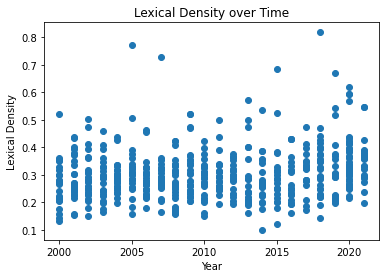

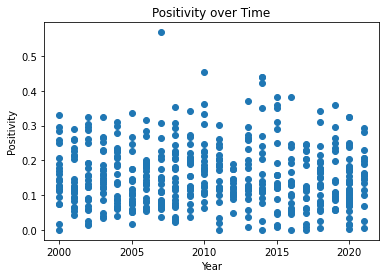

In [18]:
plt.figure()
plt.title("Lexical Density over Time")
plt.xlabel("Year")
plt.ylabel("Lexical Density")
plt.scatter(bb_data["year"],bb_data["lexical-density"])
plt.figure()
plt.title("Positivity over Time")
plt.xlabel("Year")
plt.ylabel("Positivity")
plt.scatter(bb_data["year"],bb_data["positivity"])

There's a really interesting outlier in positivity in 2007, If we look more into it, we find that it's "Party Like A Rockstar" by the Shop Boyz. If you have a second, check out the [music video](https://www.youtube.com/watch?v=82vpIsQ3lX8), it's pretty representative of the era.

The lyrical density peak in 2017 is "Girls Like You" by Maroon 5.

In [19]:
bb_data.loc[bb_data["lexical-density"].idxmax()]
bb_data.loc[bb_data["positivity"].idxmax()]


song                                           Party Like A Rockstar
artist                                                     Shop Boyz
year                                                            2007
month                                                              8
day                                                               18
success                                                           79
lyrics             yyyeaaaaaaah yyyeaaaaaaah yyyeaaaaaaah ttttota...
lexical-density                                             0.252174
positivity                                                     0.568
Name: 74209, dtype: object

Interestingly, both metrics also seem to be bottom skewed, something that we can see more clearly if we plot them in violin charts.

{'bodies': [<matplotlib.collections.PolyCollection at 0x23cc767f910>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x23cc767f880>,
 'cmins': <matplotlib.collections.LineCollection at 0x23cc767ffd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x23cc76483d0>}

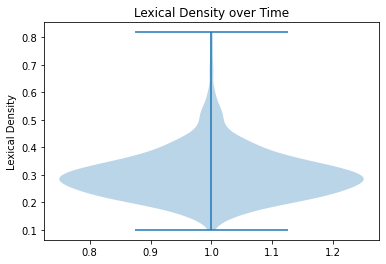

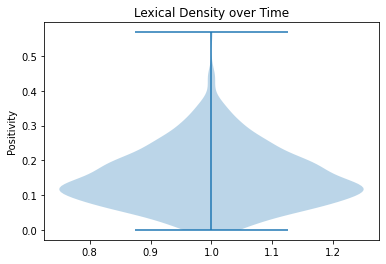

In [20]:
plt.figure()
plt.title("Lexical Density over Time")
plt.ylabel("Lexical Density")
plt.violinplot([bb_data["lexical-density"]])
plt.figure()
plt.title("Lexical Density over Time")
plt.ylabel("Positivity")
plt.violinplot([bb_data["positivity"]])

When we graph both of our target metrics over time, we see a slight trend. It appears that lexical density has increased over time, and postivity seems to have slightly decreased. To check this better, we can use just the means of each year. 

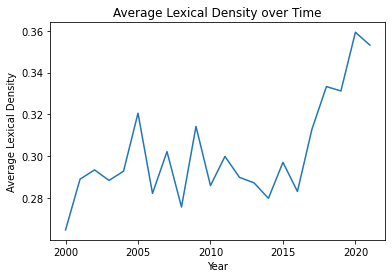

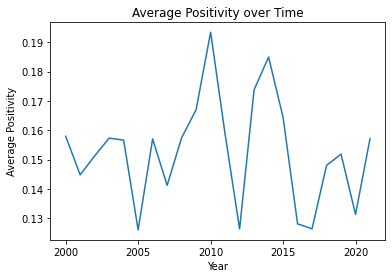

In [21]:
plt.figure()
plt.title("Average Lexical Density over Time")
plt.xlabel("Year")
plt.ylabel("Average Lexical Density")
plt.plot(bb_data.groupby("year")["lexical-density"].mean())
plt.figure()
plt.title("Average Positivity over Time")
plt.xlabel("Year")
plt.ylabel("Average Positivity")
plt.plot(bb_data.groupby("year")["positivity"].mean())

Interestingly, there does appear to be a distinct upwards trend in lexical complexity over time, especially over the past 6 years. In overall average positivity there appears to be no definite trend over time, but some interesting spikes at the turn of the decade. It is interesting to me that there are two distinct valleys, in 2012 and 2016. Both of these years were American election years, which may have something to do with the overall cultural zeigtgeist being more depressive. On the contrary, there appeaer to be distinct peaks in 2010 and 2015. I believe overall that average positivity is not a metric that can be used to examine anything about the state of American culture at the time. It's more likely just a highly random metric, and so averaging it serves no real purpose.

Let's take a look at how the two input variables interact with each other. 

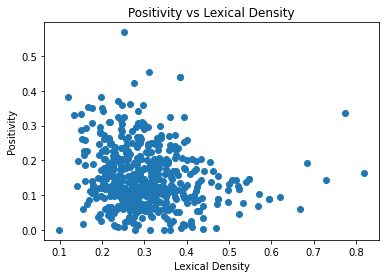

In [22]:
plt.figure()
plt.title("Positivity vs Lexical Density")
plt.xlabel("Lexical Density")
plt.ylabel("Positivity")
plt.scatter(bb_data["lexical-density"],bb_data["positivity"])

It appears that there is some slight negative correlation between the lexical density and the positivity of the song. Seemingly, more lyrically complex songs tend to be sadder than more simple songs. We believe that this result is reasonable - negative emotions require more unique words to adequately describe. There are some outliers in our data, but this trend seems to be pretty consistent.

<h1>Hypothesis Testing</h1><br>
Now that we've set some context, let's test our actual hypothesis. Our basic argument is that there is some significant correlation between this "success" metric that we've generated, and individually both lexical density and positivity. This implies that we can draw a linear regression across the data, and this will give us a way to guess the success of a song in the future based on its lexical complexity and tone. We can do a straightforward linear regression with both variables with SciPy. Let's start by plotting all three metrics we want to examine (lexical density, positivity, and success).

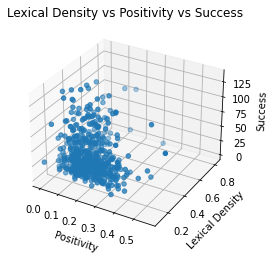

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Lexical Density vs Positivity vs Success")
ax.set_xlabel("Positivity")
ax.set_ylabel("Lexical Density")
ax.set_zlabel("Success")
ax.scatter(bb_data["positivity"],bb_data["lexical-density"],bb_data["success"])

Now let's use SciKit to generate a basic linear regression model. The output is the success, and the inputs are the positivity and lexical density. We'll have to stack the two input columns into a numpy matrix, and the output column into a seperate matrix. Using a basic Linear Regression will give us the intercepts and coefficients for a line that we can graph. 

In [24]:
from sklearn.linear_model import LinearRegression
X = np.vstack((bb_data["positivity"].to_numpy(),bb_data["lexical-density"].to_numpy())).T
y = bb_data["success"].to_numpy().reshape((518,1))
LR = LinearRegression()
LR.fit(X,y)
print("Intercept: ", LR.intercept_)
print("Coeffecients: ", LR.coef_)



Intercept:  [29.66803458]
Coeffecients:  [[-7.15895385  6.15553408]]


Now let's graph this line on the same graph as before.

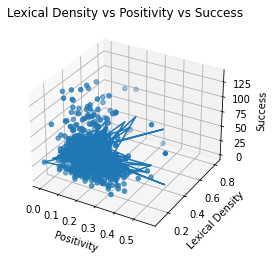

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Lexical Density vs Positivity vs Success")
ax.set_xlabel("Positivity")
ax.set_ylabel("Lexical Density")
ax.set_zlabel("Success")
ax.scatter(bb_data["positivity"],bb_data["lexical-density"],bb_data["success"])

predictions = LR.predict(X).flatten()
ax.plot(X[:,0],X[:,1],predictions)

With the nature of a 3D model, it's a little hard to see the effectiveness of the linear regression. Instead let's look at the r2 score for the predictions. We can do this, again with a simple sklearn function.

In [26]:
from sklearn.metrics import r2_score

print("R2 Score:",r2_score(y,predictions))


R2 Score: 0.0008540125088608574


This is a remarkably poor R2 Score, implying that there is no correlation at all between the three variables. Before we analyze this further, let's quickly check what linear regression looks like on both inputs individually. Let's start with lexical density.

Intercept:  [28.26187609]
Coefficient:  [[7.19545968]]
R2 Score:  0.00046870159641698717


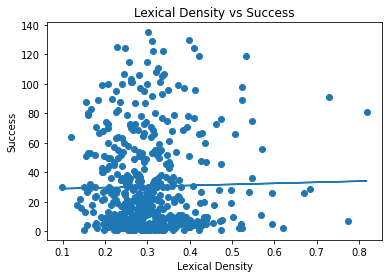

In [27]:
X = bb_data["lexical-density"].to_numpy().reshape(-1,1)
y = bb_data["success"].to_numpy().reshape(-1,1)

LR2 = LinearRegression()
LR2.fit(X,y)
print("Intercept: ", LR2.intercept_)
print("Coefficient: ", LR2.coef_)

predictions = LR2.predict(X).flatten()
plt.figure()
plt.title("Lexical Density vs Success")
plt.xlabel("Lexical Density")
plt.ylabel("Success")
plt.scatter(X,y)
plt.plot(X,predictions)

print("R2 Score: ", r2_score(y,predictions))

Intercept:  [31.69317372]
Coefficient:  [[-8.20895278]]
R2 Score:  0.0005194986833382265


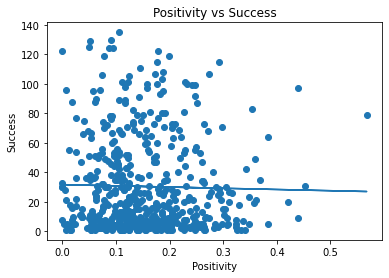

In [28]:
X = bb_data["positivity"].to_numpy().reshape(-1,1)
y = bb_data["success"].to_numpy().reshape(-1,1)

LR2 = LinearRegression()
LR2.fit(X,y)
print("Intercept: ", LR2.intercept_)
print("Coefficient: ", LR2.coef_)

predictions = LR2.predict(X).flatten()
plt.figure()
plt.title("Positivity vs Success")
plt.xlabel("Positivity")
plt.ylabel("Success")
plt.scatter(X,y)
plt.plot(X,predictions)

print("R2 Score: ", r2_score(y,predictions))

Unfortunately, the R2 values for all three regressions are very low. This demonstrates that there is basically no linear correlation between the positivity of a song, its lexical density, and its overall success. The linear regression model's predictions are far from accurate, meaning that any predictions relying on positivity or song complexity will not be accurate.

<h1>Conclusion</h1>  <br>
In conclusion, the hypothesis was ultimately disproven. Still, we believe that this analysis was still ultimately useful. Primarily, we believe that a lack of linear correlation is still valuable to know. It is interesting that we have some intrinsic belief in what makes a "summer jam", but this notion seems to not be backed up by the data at all.  
When hypothesizing why this might be, a couple of significant ideas jump to mind. There's some idea of confirmation bias. The ideal loud, fast, and exciting song that we define as a "summer banger" is inherently catchy. These types of songs definitely exist, and are likely to get stuck in your head and be generally memorable. As such they become the default for what constitutes a summer chart-topper in our heads, when in reality they make up only a minority of songs.  
<br><br>Secondly, there is the notion that the United States is incredibly vast and diverse. The music that is popular on the West Coast is radically different from the music that is popular in the Midwest, which in turn is different from the music that is popular in the South. The Billboard Hot 100 uses data from all of the United States, meaning that there is presence from all of these regions, whose music may contrast, meaning trends are hard to draw. 
<br><br>Finally, there might be some issues in the variables we used. For example, we examined the positivity of the overall song, but music is rarely every black and white. Songs, like all artistic creations are inherently personal, and as such usually convery complex ideas. It may not be entirely reasonably to assign a single "positivity" score to the lyrics. In the sme vein, the success metric may also be somewhat flawed. It might be better to reward either longevity or peak rank more, by weighting one of the two greater than the other in the calculation of the success. 
<br><br>Although both positivity and lexical-density are seemingly distinct variables, they seem to have no bearing on the success of a song over the summer. 